## Necessary operations on the Dataset


In [5]:
import shutil
import os

base_path = 'stegoimagesdataset/test/test/'

folders_to_delete = ['stego_b64', 'stego_zip']

for folder in folders_to_delete:
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Deleted folder : {folder_path}")
    else:
        print(f"Can't find the folder : {folder_path}")

Deleted folder : stegoimagesdataset/test/test/stego_b64
Deleted folder : stegoimagesdataset/test/test/stego_zip


In [6]:
import os
from PIL import Image

def convert_clean_rgba_to_rgb(root_dirs):
    for root in root_dirs:
        clean_dir = os.path.join(root, 'clean')
        if not os.path.isdir(clean_dir):
            continue

        for fname in os.listdir(clean_dir):
            if not fname.lower().endswith('.png'):
                continue

            path = os.path.join(clean_dir, fname)
            try:
                with Image.open(path) as img:
                    if img.mode == 'RGBA':
                        rgb_img = img.convert('RGB')
                        rgb_img.save(path)
                        print(f"Converted RGBA → RGB: {path}")
            except Exception as e:
                print(f"Error processing {path}: {e}")

# Exemple d'utilisation :
train_dir = 'stegoimagesdataset/train/train'
val_dir   = 'stegoimagesdataset/val/val'
test_dir  = 'stegoimagesdataset/test/test'

convert_clean_rgba_to_rgb([train_dir, val_dir, test_dir])

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/01985.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/03175.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/02649.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/01167.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/03158.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/03894.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/00668.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/01236.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/03586.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/00807.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/02584.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/00736.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/03666.png
Converted RGBA → RGB: ste

"""
## `CustomTrainAugmentation` Class

This class defines custom data augmentations for training images, which help improve the robustness of a model by introducing variations in the input data. These augmentations are applied during training to simulate real-world noise and transformations.

#### Noise Addition Methods:
- **`add_gaussian_noise`:** Adds random Gaussian noise to the image by generating noise with a specified mean and standard deviation.
- **`add_salt_pepper`:** Adds salt-and-pepper noise by randomly selecting pixels to turn either white (salt) or black (pepper).



In [1]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image, ImageFilter
import numpy as np
import random
import re
import cv2
from torchvision import transforms

class CustomTrainAugmentation:
    def __init__(self):
        # Define the base transformations applied to every image
        self.base_transform = transforms.Compose([
            # Randomly flip the image horizontally with a 50% chance
            transforms.RandomHorizontalFlip(p=0.5),

            # These are optional transformations that are currently commented out
            # transforms.RandomRotation(degrees=5),  # Randomly rotate the image by up to 5 degrees
        ])


    def __call__(self, img):
        # Apply the base transformations (e.g., flipping)
        img = self.base_transform(img)

        # Generate a random number to decide which noise effect to apply
        r = random.random()
        if r < 0.2:
            # 20% chance to apply Gaussian noise
            img = self.add_gaussian_noise(img)
        elif r < 0.4:
            # 20% chance to apply salt-and-pepper noise
            img = self.add_salt_pepper(img)
        elif r < 0.6:
            # 20% chance to apply Gaussian blur
            img = img.filter(ImageFilter.GaussianBlur(radius=1))

        # Return the final augmented image
        return img  # self.normalize(img)

    def add_gaussian_noise(self, img):
        # Convert the image to a NumPy array and normalize to [0, 1]
        np_img = np.array(img).astype(np.float32) / 255.0

        # Generate Gaussian noise with mean=0 and std=0.02
        noise = np.random.normal(0, 0.02, np_img.shape)

        # Add noise and clip the result to stay within valid range
        noisy = np.clip(np_img + noise, 0, 1)

        # Convert back to PIL image in [0, 255] range
        return Image.fromarray((noisy * 255).astype(np.uint8))

    def add_salt_pepper(self, img, amount=0.01):
        # Convert image to NumPy array
        np_img = np.array(img)
        h, w, c = np_img.shape

        # Calculate number of salt (white) pixels
        num_salt = int(amount * h * w)
        coords = [np.random.randint(0, i - 1, num_salt) for i in (h, w)]
        np_img[coords[0], coords[1], :] = 255  # Set selected pixels to white

        # Calculate number of pepper (black) pixels
        num_pepper = int(amount * h * w)
        coords = [np.random.randint(0, i - 1, num_pepper) for i in (h, w)]
        np_img[coords[0], coords[1], :] = 0  # Set selected pixels to black

        # Convert back to PIL image
        return Image.fromarray(np_img)



## `BalancedStegoDatasetGPU` Class

This class is designed for creating a balanced dataset containing both clean and stego images. It includes preprocessing and transformation steps, with the flexibility to apply additional filters like the Laplacian.


In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import random
import re
import cv2
import numpy as np

class BalancedStegoDatasetGPU(Dataset):
    def __init__(self, clean_dir, stego_dir, transform=None, device='cuda', apply_laplacian=False):
        self.device = device  # Device to store tensors (usually 'cuda' for GPU)
        self.transform = transform  # transform (e.g., augmentations)
        self.apply_laplacian = apply_laplacian  # Whether to apply Laplacian filter to images

        # Default normalization and resizing pipeline
        self.normalize = transforms.Compose([
            transforms.Resize((256, 256)),  # Resize image to 256x256
            transforms.ToTensor(),  # Convert to PyTorch tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard ImageNet mean
                                 std=[0.229, 0.224, 0.225])   # Standard ImageNet std
        ])

        self.images = []  # List of image tensors
        self.labels = []  # Corresponding labels: 0 for clean, 1 for stego

        # Get and sort all PNG files from the clean directory
        clean_imgs = sorted([f for f in os.listdir(clean_dir) if f.endswith('.png')])

        for clean_img in clean_imgs:
            clean_path = os.path.join(clean_dir, clean_img)
            base_id = os.path.splitext(clean_img)[0]  # Remove extension

            # Load clean image, apply preprocessing, and store on device
            img_clean = Image.open(clean_path).convert("RGB")
            img_clean = self.preprocess(img_clean)
            self.images.append(img_clean.to(self.device))
            self.labels.append(torch.tensor(0, dtype=torch.long, device=self.device))  # Label 0 = clean

            # Use regex to find matching stego image(s) with similar base name
            pattern = f"image_{base_id}_.+\\.png"
            stego_matches = [f for f in os.listdir(stego_dir) if re.match(pattern, f)]

            if stego_matches:
                # Randomly choose one stego image if multiple are found
                stego_img = random.choice(stego_matches)
                stego_path = os.path.join(stego_dir, stego_img)

                # Load stego image, preprocess, and store on device
                img_stego = Image.open(stego_path).convert("RGB")
                img_stego = self.preprocess(img_stego)
                self.images.append(img_stego.to(self.device))
                self.labels.append(torch.tensor(1, dtype=torch.long, device=self.device))  # Label 1 = stego

        # Stack all image and label tensors into single batched tensors
        self.images = torch.stack(self.images)
        self.labels = torch.stack(self.labels)

    def preprocess(self, img_pil):
        # Apply optional user-defined transforms first (e.g., augmentations)
        img_pil = self.transform(img_pil)

        # Convert PIL image to NumPy array for Laplacian processing
        img_np = np.array(img_pil)

        if self.apply_laplacian:
            # Apply Laplacian filter to each channel (edge enhancement)
            laplacian_channels = []
            for c in range(3):  # RGB channels
                channel = img_np[:, :, c]
                laplacian = cv2.Laplacian(channel, cv2.CV_32F, ksize=3)
                laplacian = cv2.convertScaleAbs(laplacian)  # Convert to 8-bit image
                laplacian_channels.append(laplacian)

            # Merge channels back into a 3-channel image
            img_np = np.stack(laplacian_channels, axis=-1)

        # Convert back to PIL image and apply normalization
        img_pil = Image.fromarray(img_np)
        return self.normalize(img_pil)

    def __getitem__(self, index):
        # Return (image, label) pair at the given index
        return self.images[index], self.labels[index]

    def __len__(self):
        # Return the total number of samples
        return len(self.labels)


In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
import os

train_transform = CustomTrainAugmentation()

standard_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5)  # 50% chance of flipping the image horizontally
])

# training dataset using the custom augmentation and Laplacian filtering
train_dataset = BalancedStegoDatasetGPU(
    clean_dir='stegoimagesdataset/train/train/clean',  # Path to clean training images
    stego_dir='stegoimagesdataset/train/train/stego',  # Path to stego training images
    transform=train_transform,  # Apply custom data augmentation
    device='cuda',  # Move all tensors to GPU
    apply_laplacian=True  # Apply Laplacian filter (edge enhancement)
)

# validation dataset using standard transformation and Laplacian filtering
val_dataset = BalancedStegoDatasetGPU(
    clean_dir='stegoimagesdataset/val/val/clean',  # Path to clean validation images
    stego_dir='stegoimagesdataset/val/val/stego',  # Path to stego validation images
    transform=standard_transform,  # Apply basic augmentation
    device='cuda',
    apply_laplacian=True
)

# batch size for loaders
batch_size = 32

# DataLoader for training data with shuffling enabled
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# DataLoader for validation data without shuffling
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [11]:
from collections import Counter

labels_train = [int(label) for _, label in train_dataset]
labels_val = [int(label) for _, label in val_dataset]
print(Counter(labels_train))
print(Counter(labels_val))

for input, labels in train_loader:
  print(input.size())
  print(labels.size())
  break

Counter({0: 4000, 1: 4000})
Counter({0: 2000, 1: 2000})
torch.Size([32, 3, 256, 256])
torch.Size([32])


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load a pretrained ResNet-18 model with default weights
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

in_features = model.fc.in_features  # ResNet18's last layer has input features (usually 512)

# Replace the original fc layer with a new one for binary classification (2 classes)
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # dropout for regularization (reduces overfitting)
    nn.Linear(in_features, 2)  # New linear layer with 2 output units: [clean, stego]
)

# device: GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the entire model to the selected device
model = model.to(device)



Using device: cuda


## Training Function with Early Stopping and LR Scheduler
The function below defines a complete training loop for a PyTorch model.
It includes key features such as:

- Training and validation steps per epoch

- Accuracy and loss tracking

- ReduceLROnPlateau scheduler: automatically lowers the learning rate when the validation loss plateaus

- Early stopping: stops training if no improvement is observed after a certain number of epochs

- Model checkpointing: saves the model with the best validation performance to disk


In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import time

from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import time

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10, save_path="best_model.pth"):

    best_val_loss = float('inf')       # Track best validation loss seen so far
    epochs_no_improve = 0              # Count epochs without improvement

    # Learning rate scheduler: reduce LR if validation loss plateaus
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',        # We want to minimize the validation loss
        factor=0.5,        # Reduce LR by half when triggered
        patience=5,        # Trigger if no improvement for 5 consecutive epochs
    )

    print(f"Starting training for model: {model.__class__.__name__} at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())} for {num_epochs} epochs")

    for epoch in range(1, num_epochs + 1):
        # ---- TRAINING PHASE ----
        model.train()  # Set model to training mode (enables dropout, etc.)
        running_loss = 0.0
        correct = total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to selected device

            optimizer.zero_grad()             # Reset gradients
            outputs = model(inputs)           # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            loss.backward()                   # Backward pass
            optimizer.step()                  # Update weights

            # Accumulate loss and accuracy statistics
            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)  # Get predicted classes
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100 * correct / total

        # ---- VALIDATION PHASE ----
        model.eval()  # Set model to evaluation mode (disables dropout, etc.)
        val_loss = 0.0
        val_correct = val_total = 0

        with torch.no_grad():  # Disable gradient computation (faster and uses less memory)
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / val_total
        val_acc = 100 * val_correct / val_total

        # Update learning rate scheduler based on validation loss
        scheduler.step(val_loss)

        # ---- MODEL CHECKPOINTING & EARLY STOPPING ----
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)  # Save best model to disk
            improve_str = "New Best Model found!"
        else:
            epochs_no_improve += 1
            improve_str = f"No improvement ({epochs_no_improve}/{patience})"

        # Log training progress
        print(
            f"Epoch {epoch:>3}/{num_epochs}  "
            f"| Train Loss: {train_loss:.4f}, Train Acc: {train_acc:5.2f}%  "
            f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:5.2f}%  "
            f"{improve_str}"
        )

        # Stop training early if validation loss hasn't improved for `patience` epochs
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch} epochs (val_loss didn't drop).")
            break

    print(f"Training complete. Best Validation Loss: {best_val_loss:.4f}")
    return model




## Loss Function, Optimizer, and Training Launch
In this cell, we define the loss function and the optimizer, then launch the training process:

- CrossEntropyLoss is used, which is the standard choice for multi-class classification problems.

- The Adam optimizer is initialized with a learning rate of 1e-4 and a small weight decay (1e-4) for regularization.

The training loop is started using the previously defined train function, with:

- 100 maximum epochs

- 15 patience epochs for early stopping (training stops early if validation loss doesn't improve)

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # Cross entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4) # Adam optimizer

trained_model = train(model, train_loader, val_loader, criterion, optimizer, 100, 15)

Starting training for model: ResNet at 2025-05-02 16:38:37 for 100 epochs
Epoch   1/100  | Train Loss: 0.5703, Train Acc: 66.75%  | Val Loss: 0.0428, Val Acc: 98.75%  New Best Model found!
Epoch   2/100  | Train Loss: 0.3001, Train Acc: 81.29%  | Val Loss: 0.0304, Val Acc: 99.95%  New Best Model found!
Epoch   3/100  | Train Loss: 0.2540, Train Acc: 85.90%  | Val Loss: 0.1680, Val Acc: 99.75%  No improvement (1/15)
Epoch   4/100  | Train Loss: 0.2341, Train Acc: 87.00%  | Val Loss: 0.0042, Val Acc: 99.95%  New Best Model found!
Epoch   5/100  | Train Loss: 0.2262, Train Acc: 88.21%  | Val Loss: 0.0063, Val Acc: 99.95%  No improvement (1/15)
Epoch   6/100  | Train Loss: 0.2195, Train Acc: 88.78%  | Val Loss: 1.3698, Val Acc: 59.35%  No improvement (2/15)
Epoch   7/100  | Train Loss: 0.2022, Train Acc: 90.49%  | Val Loss: 0.0068, Val Acc: 99.95%  No improvement (3/15)
Epoch   8/100  | Train Loss: 0.1836, Train Acc: 91.38%  | Val Loss: 0.0045, Val Acc: 99.97%  No improvement (4/15)
Epoch 

## Test Set Preparation (Standard and Robust)
This cell prepares two separate test datasets and their DataLoaders:

- Standard Test Set: Uses minimal augmentation (random horizontal flip only) and is meant to evaluate the model in normal, clean test conditions.

- Robust Test Set: Uses the same images but applies more aggressive augmentations like noise and blur (via CustomTrainAugmentation) to simulate challenging or perturbed inputs.

Both datasets use Laplacian filtering to emphasize edges and details, which may help the model detect subtle steganographic artifacts.

By comparing performance on both sets, we can assess not only accuracy, but also the robustness of the trained model.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
import os

standard_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5)
])
test_dataset = BalancedStegoDatasetGPU(
    clean_dir='stegoimagesdataset/test/test/clean',
    stego_dir='stegoimagesdataset/test/test/stego',
    transform=standard_transform,
    device='cuda',
    apply_laplacian=True
)
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

robust_test_transform = CustomTrainAugmentation()

robust_test_dataset = test_dataset = BalancedStegoDatasetGPU(
    clean_dir='stegoimagesdataset/test/test/clean',
    stego_dir='stegoimagesdataset/test/test/stego',
    transform=robust_test_transform,
    device='cuda',
    apply_laplacian=True
)

robust_test_loader = DataLoader(robust_test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch


# Function to evaluate the model on a given DataLoader
def test_model(model, loader, device):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            all_images.append(images.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_images = torch.cat(all_images)

    return all_images, all_preds, all_labels

# Function to print a classification report (precision, recall, f1-score)
def generate_classification_report(labels, preds, classes):
    report = classification_report(labels, preds, target_names=classes)
    print("\n=== 📊 Rapport de classification ===\n")
    print(report)

# Function to display a confusion matrix
def plot_confusion_matrix(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Clean', 'Stego'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()



=== 📊 Rapport de classification ===

              precision    recall  f1-score   support

       clean       1.00      0.97      0.99      2000
       stego       0.97      1.00      0.99      2000

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



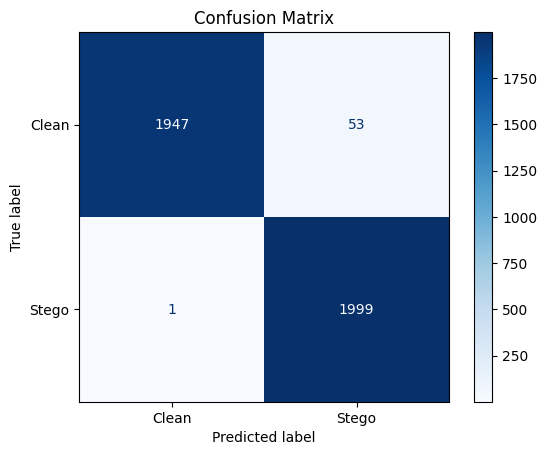


=== 📊 Rapport de classification ===

              precision    recall  f1-score   support

       clean       0.86      0.93      0.90      2000
       stego       0.93      0.85      0.89      2000

    accuracy                           0.89      4000
   macro avg       0.90      0.89      0.89      4000
weighted avg       0.90      0.89      0.89      4000



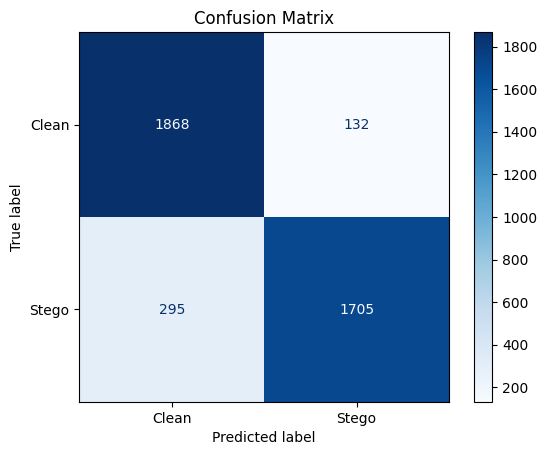

In [6]:
model.load_state_dict(torch.load('best_model.pth'))  # Load the best model saved during training

# Evaluate the model on the standard test dataset
images, preds, labels = test_model(model, test_loader, device)

classes = ['clean', 'stego']  # These are the two classes in the classification task

generate_classification_report(labels, preds, classes)

# Plot the confusion matrix for the standard test set
plot_confusion_matrix(model, test_loader)

# Evaluate the model on the robust test dataset (with stronger augmentations)
images_robust, preds_robust, labels_robust = test_model(model, robust_test_loader, device)

generate_classification_report(labels_robust, preds_robust, classes)

plot_confusion_matrix(model, robust_test_loader)


